In [3]:
import torch
from torch import nn

# CASE 1
### 範例一：沒有batch, data(如句子)只有一個時間點的資料(seq_len=1, 如只含有一單詞)

In [ ]:
#network parameters
input_size = 2   ## 輸入神經元 Xt (t指某個時間) 的特徵向量長度
hidden_size = 2  ## hidden h 的特徵向量長度
num_layers = 1   ## 只有一層 hidden layer A

#data parameters
seq_len = 1
# (case 1不使用batch)batch_size = 2
data_dim = input_size

In [ ]:
#input data
data = torch.randn(seq_len, data_dim)
data

tensor([[-0.8055, -2.1205]])

* data的shpae是[1,2], 與官網說明(如下)完全一致
> -- **input**: tensor of shape (*L*,*H_in*) for unbatched input -- *L* 是 seq_len, *H_in* 是 input_size




In [ ]:
#official rnn in pytorch
ornn = nn.RNN(input_size, hidden_size, num_layers)

In [ ]:
#init hidden state
h0 = torch.randn(num_layers,hidden_size)
h0

tensor([[-1.6190, -0.7052]])

* h0的shape是[1,2], 與官網說明(如下)完全一致
> -- **h_0**: tensor of shape (*D* * *num_layers*, *H_out*) for unbatched input -- *D* 是 1 (非雙向), *H_out* 是 hidden_size

In [ ]:
# 輸入data，根據h0執行ornn，也可以不用自行提供h0~
official_output, official_hn = ornn(data,h0)
official_output, official_hn # 兩者結果會相同,因為seq_len=1,official_output就是official_hn

(tensor([[ 0.9922, -0.2327]], grad_fn=<SqueezeBackward1>),
 tensor([[ 0.9922, -0.2327]], grad_fn=<SqueezeBackward1>))

* official_output的shape是[1,2],與官網說明(如下)完全一致
> --**output**: tensor of shape (*L*, *D* * *H_out*) for unbatched input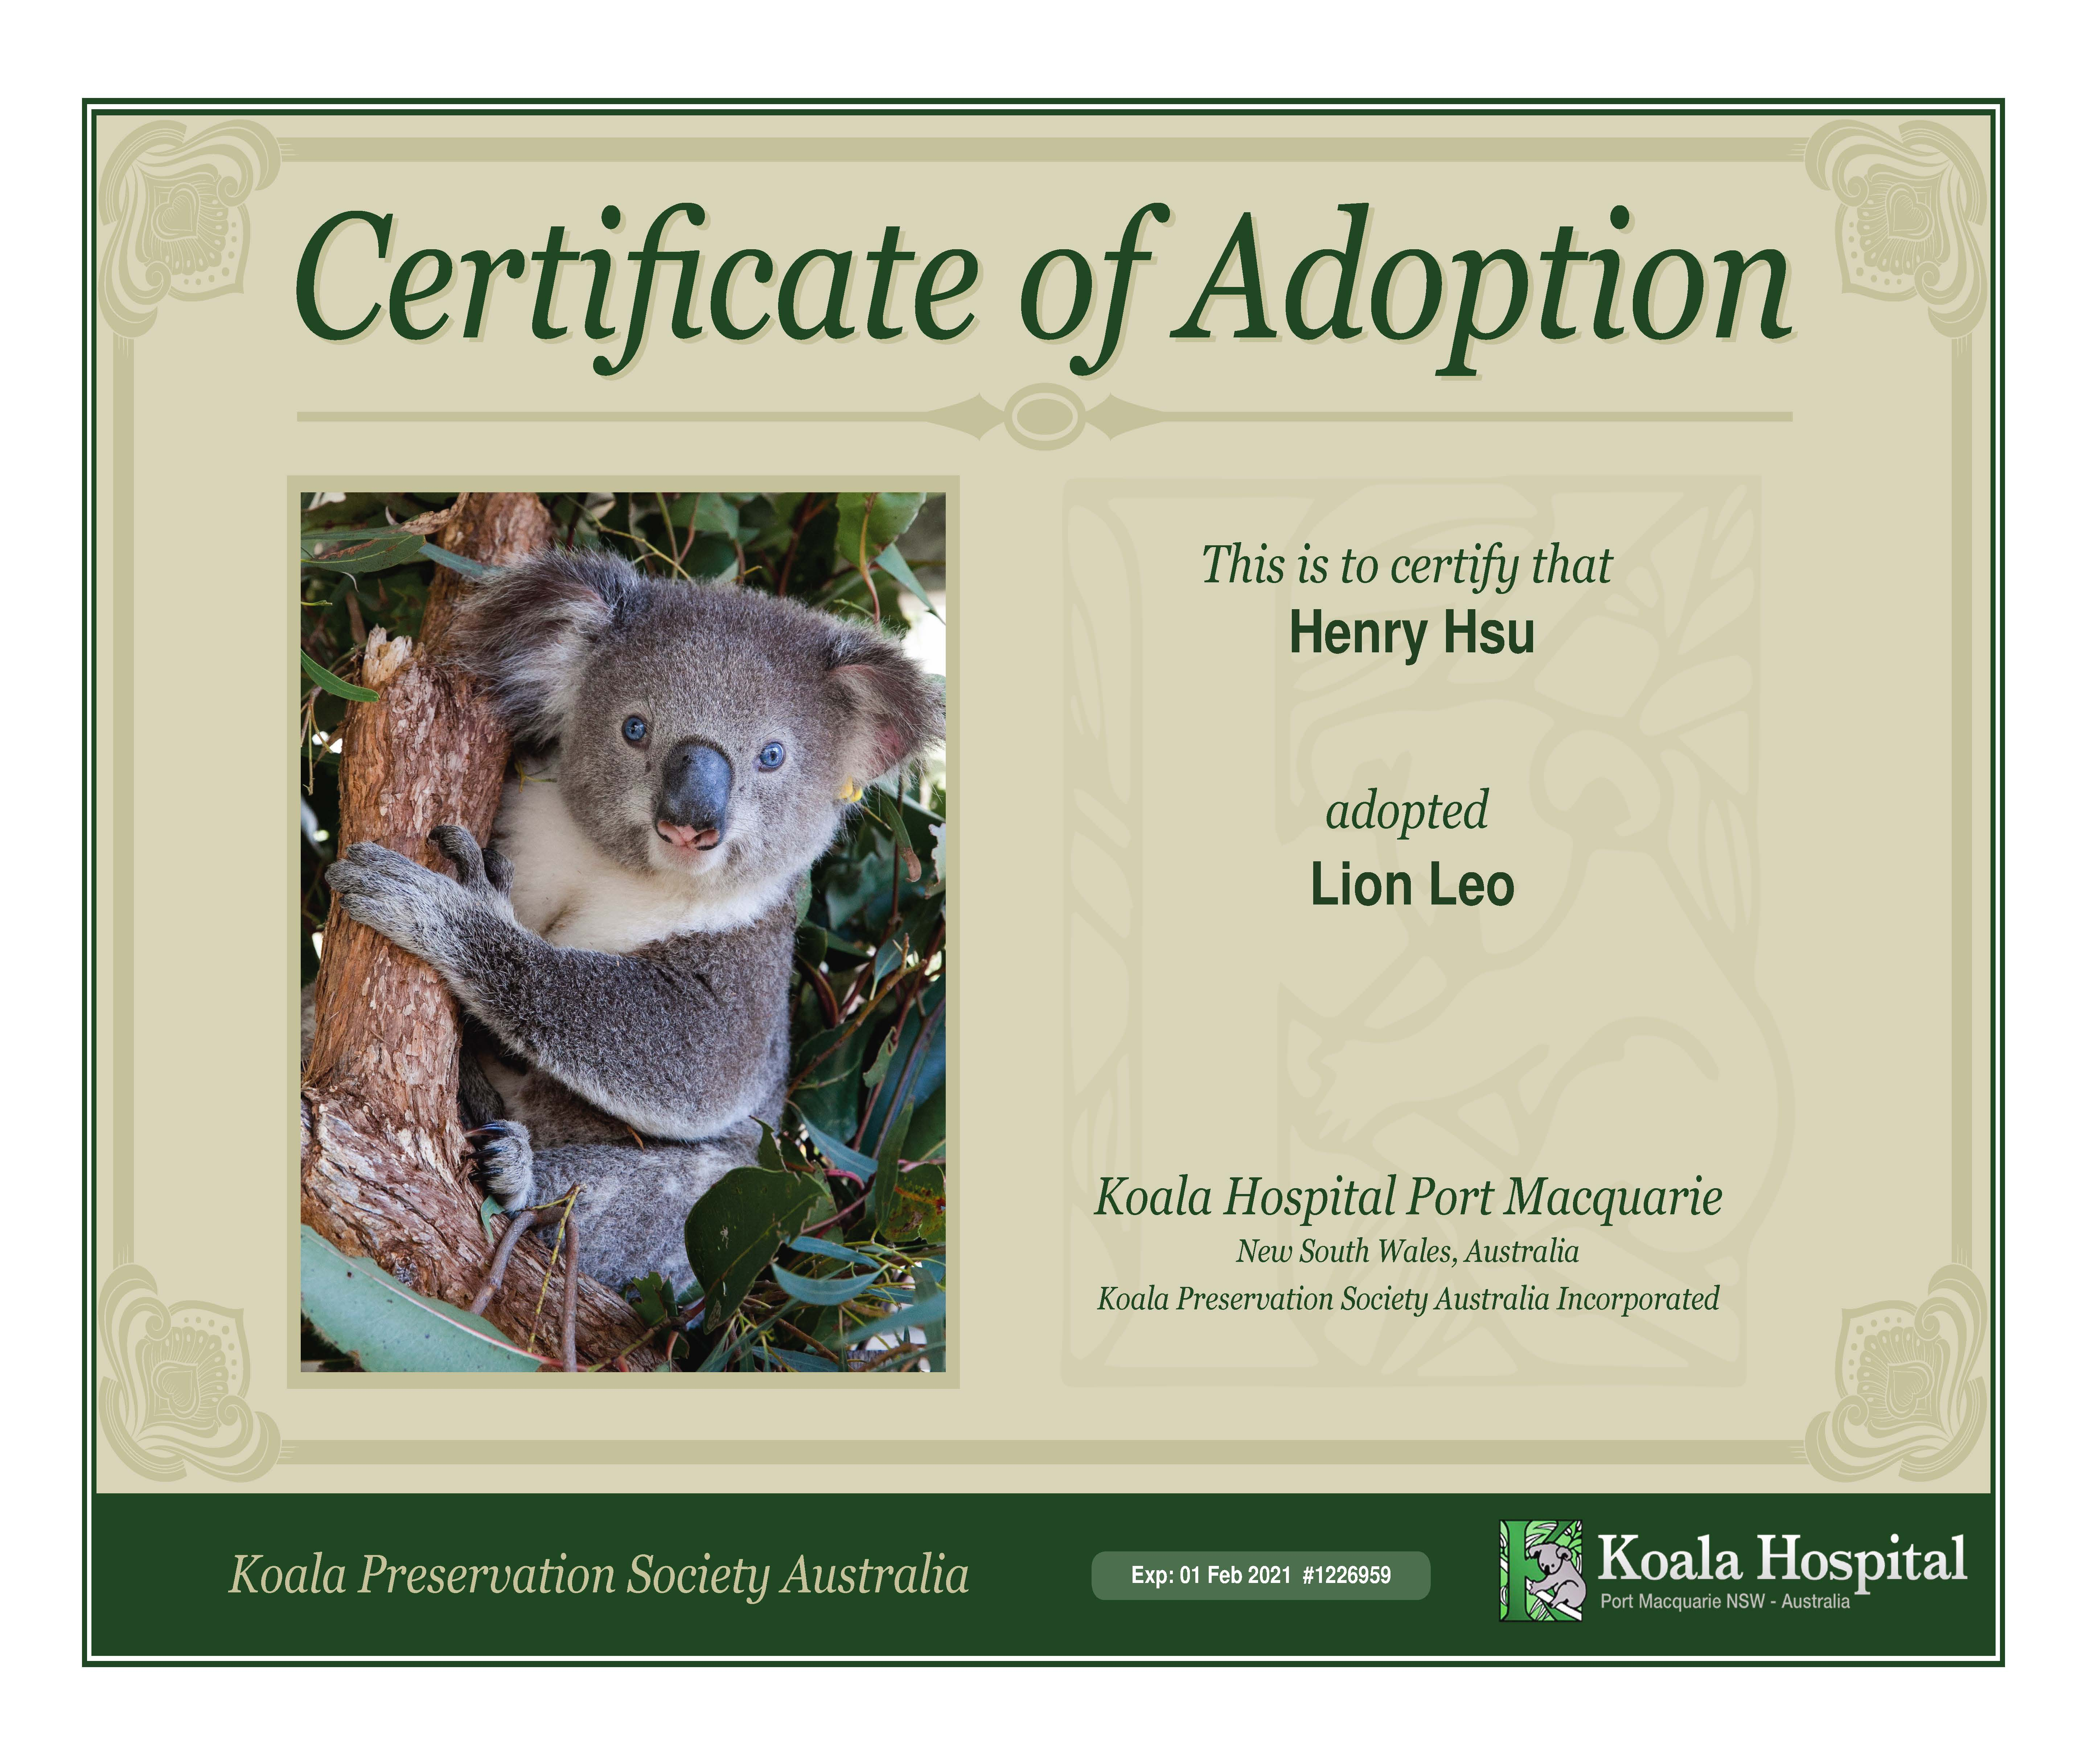
* official_hn的shape是[1,2],與官網說明(如下)完全一致
> --**h_n**--: tensor of shape (*D* * *num_layers*, *H_out*) for unbatched input

輔助用--顯示模型中不同層的`name`與`weight`
```python
for name, param in ornn.named_parameters():
    print(name, param.data)
# 顯示實例
# weight_ih_l0 tensor([[ 0.5115, -0.6934],
#             [ 0.3216,  0.3994]])
# weight_hh_l0 tensor([[-0.6004, -0.4624],
#             [-0.6839,  0.4299]])
# bias_ih_l0 tensor([0.1310, 0.1641])
# bias_hh_l0 tensor([ 0.2844, -0.0994])
```


顯示模型中不同層的`name`與`weight`的另一個方法
```python
ornn.state_dict()
# 顯示實例
# OrderedDict([('weight_ih_l0',
#         tensor([[ 0.5115, -0.6934],
#             [ 0.3216,  0.3994]])),
#         ('weight_hh_l0',
#         tensor([[-0.6004, -0.4624],
#             [-0.6839,  0.4299]])),
#         ('bias_ih_l0', tensor([0.1310, 0.1641])),
#         ('bias_hh_l0', tensor([ 0.2844, -0.0994]))])
```



In [ ]:
# 自行計算rnn的一種方式,也是最簡化的方式(用.data取代nn.Parameter)
XWi = data@ornn.weight_ih_l0.data.T # 執行Xt*W_ih^T
#[1,2] <- [1,2]@[2,2]
b_ih = ornn.bias_ih_l0.data
#[1,2] <- [1,2]
hWh = h0@ornn.weight_hh_l0.data.T # h0*W_hh^T
#[1,2] <- [1,2]@[2,2]
b_hh = ornn.bias_hh_l0.data
#[1,2] <- [1,2]
resultf = torch.tanh(XWi+b_ih+hWh+b_hh)
#[1,2] <- [1,2]
resultf

tensor([[ 0.9922, -0.2327]])



```python
# 自行計算rnn的其依方式
XWi = torch.matmul(data,ornn.state_dict()['weight_ih_l0'].T) # Xt*W_ih^T
b_ih = ornn.state_dict()['bias_ih_l0']
hWh = torch.matmul(h0,ornn.state_dict()['weight_hh_l0'].T) # h0*W_hh^T
b_hh = ornn.state_dict()['bias_hh_l0']

result = torch.tanh(XWi+b_ih+hWh+b_hh)
```


```python
# 自行計算rnn的另一種方式(用@取代matmul)
XWi = data@torch.nn.Parameter(ornn.weight_ih_l0.T) # Xt*W_ih^T
b_ih = torch.nn.Parameter(ornn.bias_ih_l0)
hWh = h0@torch.nn.Parameter(ornn.weight_hh_l0.T) # h0*W_hh^T
b_hh = torch.nn.Parameter(ornn.bias_hh_l0)

result0 = torch.tanh(XWi+b_ih+hWh+b_hh)
```
* `resultf`與`official_hn`(`official_output`),結果相同
* `result`、`result0`、`resultf等,三個結果均相同


# CASE 2
### 範例二：沒有batch, data(如句子)有兩個時間點的資料(seq_len=2, 如只含有2單詞)

In [ ]:
#network parameters
input_size = 2   # 輸入神經元 Xt (t指某個時間) 的特徵向量長度
hidden_size = 2  # hidden h 的特徵向量長度
num_layers = 1   # 只有一層 hidden layer A

#data parameters
seq_len = 2
data_dim = input_size

In [ ]:
#input data
data = torch.randn(seq_len, data_dim)
data

tensor([[0.3186, 0.2621],
        [0.0803, 0.1127]])

* data的shpae是[2,2], 與官網說明(如下)完全一致
> -- **input**: tensor of shape (*L*,*H_in*) for unbatched input -- *L* 是 seq_len, *H_in* 是 input_size

In [ ]:
#official rnn in pytorch
ornn = nn.RNN(input_size, hidden_size, num_layers)

In [ ]:
#init hidden state
h0 = torch.randn(num_layers,hidden_size)
h0

tensor([[ 0.8117, -1.3520]])

* h0的shape是[1,2], 與官網說明(如下)完全一致
> -- **h_0**: tensor of shape (*D* * *num_layers*, *H_out*) for unbatched input -- *D* 是 1 (非雙向), *H_out* 是 hidden_size

In [ ]:
#輸入data，根據h0執行ornn
official_output, official_hn = ornn(data,h0)
official_output, official_hn ## official_output的最後一個row跟official_hn是一樣的

(tensor([[-0.4101,  0.3046],
         [-0.2281,  0.7439]], grad_fn=<SqueezeBackward1>),
 tensor([[-0.2281,  0.7439]], grad_fn=<SqueezeBackward1>))

* official_output的shape是[2,2],與官網說明(如下)完全一致
> --**output**: tensor of shape (*L*, *D* * *H_out*) for unbatched input
* official_hn的shape是[1,2],與官網說明(如下)完全一致
> --**h_n**--: tensor of shape (*D* * *num_layers*, *H_out*) for unbatched input

In [ ]:
# 自行計算rnn：此時 X(t) 是 data[0]
XWi = data[0]@ornn.weight_ih_l0.data.T # 執行Xt*W_ih^T
#[1,2] <- [1,2]@[2,2]
b_ih = ornn.bias_ih_l0.data
#[1,2] <- [1,2]
hWh = h0@ornn.weight_hh_l0.data.T # h0*W_hh^T
#[1,2] <- [1,2]@[2,2]
b_hh = ornn.bias_hh_l0.data
#[1,2] <- [1,2]
h1 = torch.tanh(XWi+b_ih+hWh+b_hh)
#[1,2] <- [1,2]+[1,2]+[1,2]+[1,2]
h1

tensor([[-0.4101,  0.3046]])

In [ ]:
# 此時輸入是 X(t+1) 是 data[1] , h1 是 result
XWi = data[1]@ornn.weight_ih_l0.data.T # X(t+1)*W_ih^T
#[1,2] <- [1,2]@[2,2]
hWh = h1@ornn.weight_hh_l0.data.T # h1*W_hh^T
#[1,2] <- [1,2]@[2,2]
result = torch.tanh(XWi+b_ih+hWh+b_hh)
#[1,2] <- [1,2]+[1,2]+[1,2]+[1,2]
result

tensor([[-0.2281,  0.7439]])

* `result`跟`official_hn`是一樣的
* `h1`與`result`合起來跟`official_output`是一樣的

# CASE 3

### 範例三：有batch, data(如句子)只有一個時間點的資料(seq_len=1, 如只含有一單詞) <font color="red">`batch_first=False`(by default)</font>

In [ ]:
#network parameters
input_size = 2   # 輸入神經元 Xt (t指某個時間) 的特徵向量長度
hidden_size = 3  # hidden h 的特徵向量長度
num_layers = 1   # 只有一層 hidden layer A

In [ ]:
#data parameters
seq_len = 1
batch_size = 2  ## case3 使用 batch
data_dim = input_size

In [ ]:
#input data
data = torch.randn(seq_len, batch_size, data_dim)
data

tensor([[[ 1.3097,  0.5200],
         [-0.0141,  0.9497]]])

* data的shpae是[1,2,2], 與官網說明(如下)完全一致
> -- **input**: tensor of shape (*L*, *N*, *H_in*) when `batch_first=Falset` -- *L* 是 seq_len, *N* 是 batch_size, *H_in* 是 input_size

In [ ]:
#official rnn in pytorch
ornn = nn.RNN(input_size, hidden_size, num_layers)

In [ ]:
#init hidden state
h0 = torch.randn(num_layers,batch_size,hidden_size)
h0

tensor([[[ 0.1118,  1.9961, -1.8162],
         [-2.0644, -1.5025, -0.8198]]])

* h0的shape是[1,2,3], 與官網說明(如下)完全一致
> -- **input**: tensor of shape (*D* * *num_layers*, *N*, *H_out*) -- *D* 是 1 (非雙向), *N* 是 batch_size, *H_out* 是 hidden_size

In [ ]:
#輸入data，根據h0執行ornn
official_output, official_hn = ornn(data,h0)
official_output, official_hn # 兩者結果會相同,因為seq_len=1,official_output就是official_hn

(tensor([[[-0.5961,  0.2450, -0.4397],
          [ 0.7579, -0.9576,  0.0932]]], grad_fn=<StackBackward0>),
 tensor([[[-0.5961,  0.2450, -0.4397],
          [ 0.7579, -0.9576,  0.0932]]], grad_fn=<StackBackward0>))

* official_output的shape是[1,2,3],與官網說明(如下)完全一致
> --**output**: tensor of shape (*L*, *N*, *D* * *H_out*) when batch_first=False
* official_hn的shape是[1,2,3],與官網說明(如下)完全一致
> --**h_n**--: tensor of shape (*D* * num_layers, *N*, *H_out*)


```python
for name, param in ornn.named_parameters():
    print(name, param.data)
    
# 顯示實例
# weight_ih_l0 tensor([[ 0.2118,  0.1362],
#             [-0.2425, -0.0603],
#             [-0.2240, -0.1886]])
# weight_hh_l0 tensor([[-0.5366, -0.1552,  0.1902],
#             [ 0.5705,  0.2271, -0.4266],
#             [ 0.2376, -0.4090, -0.5661]])
# bias_ih_l0 tensor([ 0.1009, -0.4630,  0.1333])
# bias_hh_l0 tensor([-0.4209, -0.2299, -0.4520])
```
* 注意`weight_ih_l0`的下標是`ih` , `i`是`input`(size為2) , `h`是`hidden`(size為3), 但`weight_ih_l0`的size是(3,2)


In [ ]:
# 自行計算rnn的一種方式,也是最簡化的方式(用.data取代nn.Parameter)
XWi = data@ornn.weight_ih_l0.data.T # 執行Xt*W_ih^T
#[1,2,3] <- [1,2,2]@[2,3]
b_ih = ornn.bias_ih_l0.data
#[1,3] <- [1,3]
hWh = h0@ornn.weight_hh_l0.data.T # h0*W_hh^T
#[1,2,3] <- [1,2,3]@[3,3]
b_hh = ornn.bias_hh_l0.data
#[1,3] <- [1,3]
resultf = torch.tanh(XWi+b_ih+hWh+b_hh)
#[1,2,3] <- [1,2,3]+[1,3]+[1,2,3]+[1,3] ## [1,3] 會擴展成 [2,3] 再展成 [1,2,3]
resultf

tensor([[[-0.5961,  0.2450, -0.4397],
         [ 0.7579, -0.9576,  0.0932]]])

* `result`跟`official_hn`(`official_hn`)是一樣的

# CASE -- Customized RNN Model

### 自訂具結構性的RNN模型(根據之前`自行計算rnn方式`)

In [ ]:
#rnn implemented by myself
class MyRNN():
    def __init__(self):
        #keep weights and bias parameters the same with official rnn
        # to make the compare with official rnn by final result
        self.W_ih = torch.nn.Parameter(ornn.weight_ih_l0.T)
        self.b_ih = torch.nn.Parameter(ornn.bias_ih_l0)
        self.W_hh = torch.nn.Parameter(ornn.weight_hh_l0.T)
        self.b_hh = torch.nn.Parameter(ornn.bias_hh_l0)
        self.ht = torch.nn.Parameter(h0)
        self.myoutput = []

    def forward(self,x): ## x 就是之後將輸入的data
        for i in range(seq_len):
            igates = x[i] @ self.W_ih + self.b_ih
            hgates = self.ht @ self.W_hh + self.b_hh
            self.ht = torch.tanh(igates + hgates)
            self.myoutput.append(self.ht)
        return self.ht,self.myoutput

In [ ]:
myrnn = MyRNN()
myht,myoutput = myrnn.forward(data)
myht,myoutput

(tensor([[[-0.5961,  0.2450, -0.4397],
          [ 0.7579, -0.9576,  0.0932]]], grad_fn=<TanhBackward0>),
 [tensor([[[-0.5961,  0.2450, -0.4397],
           [ 0.7579, -0.9576,  0.0932]]], grad_fn=<TanhBackward0>)])

* 注意如果要寫成 myht, myoutput = myrnn(data), `class MyRNN()`要改成如下

In [ ]:
class MyRNN(nn.Module): # 修改過, 否則 object is not callable
    def __init__(self):
        super(MyRNN,self).__init__() # 修改過, 否則 object is not callable

        self.W_ih = torch.nn.Parameter(ornn.weight_ih_l0.T)
        self.b_ih = torch.nn.Parameter(ornn.bias_ih_l0)
        self.W_hh = torch.nn.Parameter(ornn.weight_hh_l0.T)
        self.b_hh = torch.nn.Parameter(ornn.bias_hh_l0)
        self.ht = torch.nn.Parameter(h0)
        self.myoutput = []

    def forward(self,x):
        for i in range(seq_len):
            igates = torch.matmul(x[i],self.W_ih) + self.b_ih
            hgates = torch.matmul(self.ht,self.W_hh) + self.b_hh
            self.ht = torch.nn.Parameter(torch.tanh(igates + hgates)) # 修改過
            # 若上行沒修改過,則 cannot assign 'torch.FloatTensor' as parameter ht
            # 或是上行不執行, 以下self.ht直接用 torch.tanh(igates + hgates)取代
            self.myoutput.append(self.ht.data)
        return self.ht.data,self.myoutput

In [ ]:
myrnn = MyRNN()
myht,myoutput = myrnn.forward(data)
myht,myoutput

(tensor([[[-0.5961,  0.2450, -0.4397],
          [ 0.7579, -0.9576,  0.0932]]]),
 [tensor([[[-0.5961,  0.2450, -0.4397],
           [ 0.7579, -0.9576,  0.0932]]])])

# [CLASS torch.nn.RNN 官網說明](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN)

# RNN VS. LSTM

## <font color="red">C1 -- RNN,且`batch_first=False`(by default) 附 結構圖</font>

In [9]:
input_size = 5 ##L
hidden_size = 5*2 ##L
num_layers = 2 ##L

seq_len = 3 ##L
batch_size = 4 ##L
data_dim = input_size

In [9]:
data = torch.randn(seq_len, batch_size, data_dim) ## 給 ornn 模型使用
"""data 的 shape, 就是 seq_len,batch_size,data_dim"""

ornn = nn.RNN(input_size, hidden_size, num_layers) # batch_first = False (by default)


h0 = torch.randn(num_layers,batch_size,hidden_size) # optional -- 可以不提供
"""h0 的 shape, 就是 num_layers,batch_size,hidden_size"""

ornn_out, o_hn = ornn(data,h0) # h0 可以不提供
data.shape, h0.shape, ornn_out.shape, o_hn.shape

(torch.Size([3, 4, 5]),
 torch.Size([2, 4, 10]),
 torch.Size([3, 4, 10]),
 torch.Size([2, 4, 10]))

* ornn_out的shape是[3,4,10],與官網說明(如下)完全一致
> --**output**: tensor of shape (*L*, *N*, *D* * *H_out*) when batch_first=False
* o_hn的shape是[2,4,10],與官網說明(如下)完全一致
> --**h_n**--: tensor of shape (*D* * num_layers, *N*, *H_out*)

In [8]:
## 顯示模型中的weights與bias
for name, param in ornn.named_parameters():
  print(name, param.data.shape)

weight_ih_l0 torch.Size([10, 5])
weight_hh_l0 torch.Size([10, 10])
bias_ih_l0 torch.Size([10])
bias_hh_l0 torch.Size([10])
weight_ih_l1 torch.Size([10, 10])
weight_hh_l1 torch.Size([10, 10])
bias_ih_l1 torch.Size([10])
bias_hh_l1 torch.Size([10])


<img src="./images/shapes.jpg">

## <font color="red">C2 -- RNN,且`batch_first=True`</font>

In [ ]:
N = 256    ## batch_size
L = 150    ## tokens(seq_len)
Hin = 256   ## input_size
Hout = 128  ## hidden_size

In [4]:
ndata = torch.randn(N, L, Hin) ## 給 nrnn 模型使用 (假設此 ndata 是經過 Embedding Model 處理後的output)

nrnn = nn.RNN(Hin, Hout, 1, batch_first=True) ## 1 指的是 num_layers

nrnn_out, nhn = nrnn(ndata) ## 不提供 h_0
ndata.shape, nrnn_out.shape, nhn.shape

(torch.Size([256, 150, 256]),
 torch.Size([256, 150, 128]),
 torch.Size([1, 256, 128]))

In [5]:
## 顯示模型中的weights與bias
for name, param in nrnn.named_parameters():
  print(name, param.data.shape)

weight_ih_l0 torch.Size([128, 256])
weight_hh_l0 torch.Size([128, 128])
bias_ih_l0 torch.Size([128])
bias_hh_l0 torch.Size([128])


## <font color="red">C3 -- LSTM,且`batch_first=True`</font>

In [ ]:
N = 256    ## batch_size
L = 150    ## tokens(seq_len)
Hin = 256   ## input_size
Hout = 128  ## hidden_size

In [7]:
embout = torch.randn(256, 150, 256)   # batch =256, tokens(seq_len) = 150, input_size = 256

lstm = nn.LSTM(256, 128, 1, batch_first=True)

out, (hn, cn) = lstm(embout)
embout.shape, out.shape, hn.shape, cn.shape

(torch.Size([256, 150, 256]),
 torch.Size([256, 150, 128]),
 torch.Size([1, 256, 128]),
 torch.Size([1, 256, 128]))

In [8]:
## 顯示模型中的weights與bias
for name, param in lstm.named_parameters():
  print(name, param.data.shape)

weight_ih_l0 torch.Size([512, 256])
weight_hh_l0 torch.Size([512, 128])
bias_ih_l0 torch.Size([512])
bias_hh_l0 torch.Size([512])




---



## <font color="red">C4 -- LSTM,且`batch_first=True`</font>

In [10]:
# data.shape, h0.shape, official_output.shape, official_hn.shape, ndat.shape, nrnn_out.shape, nhn.shape
lstmn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

input = torch.randn(batch_size, seq_len, data_dim)

output, (hn, cn) = lstmn(input)
output.shape, hn.shape, cn.shape

(torch.Size([4, 3, 10]), torch.Size([2, 4, 10]), torch.Size([2, 4, 10]))

In [11]:
## 顯示模型中的weights與bias
for name, param in lstmn.named_parameters():
  print(name, param.data.shape)

weight_ih_l0 torch.Size([40, 5])
weight_hh_l0 torch.Size([40, 10])
bias_ih_l0 torch.Size([40])
bias_hh_l0 torch.Size([40])
weight_ih_l1 torch.Size([40, 10])
weight_hh_l1 torch.Size([40, 10])
bias_ih_l1 torch.Size([40])
bias_hh_l1 torch.Size([40])


* <font color="red">`lstmn`的`parameters`數量,對比**C1**中,`ornn`的`parameters`數量,前者是後者的4倍。因為`RNN`的每一個輸出運算,在`LSTM`中,包括`% Long-Term To Remember`, `% Potential Memory To Remember`, `Potential Long-Term Memory`, `% Potential Memory To Remember`等四個單元運算,所以才會有`4倍`的模型參數</font>